<a href="https://colab.research.google.com/github/Sylar257/Sequence_Labeling_Project/blob/master/Sequence_labeling_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will be implementing the [Empower Sequence Labeling with Task-Aware Neural Language Model](https://arxiv.org/pdf/1709.04109.pdf) paper

In [0]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from utils import *
import torch.nn.functional as F
decive = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
class Highway(nn.Module):
    """
    Highway network
    """
    def __init__(self, size, num_layers=1, dropout=0.5):
        """
        size: size of Linear layer (should match input size)
        num_layers: number of transform and gate layers
        dropout: dropout rate
        """
        super(Highway, self).__init__()
        self.size = size
        self.num_layers = num_layers
        self.transform = nn.ModuleList() # A list of transform layers
        self.gate = nn.ModuleList()      # A list of gate layers
        self.dropout = torch.nn.Dropout(p=dropout)

        for i in range(num_layers):
            transform = nn.Linear(size, size)
            gate = nn.Linear(size, size)
            self.transform.append(transform)
            self.gate.append(gate)
    def forward(self, x):
        """
        Forward-prop.
        Returns a tensor with the same dimensions as input tensor
        """

        transformed = F.relu(self.transform[0](x))  # transform with the first transform layer
        g = F.sigmoid(self.gate[0](x))              # calculate how much of the transformed input to keep

        out = self.dropout(g*transformed + (1-g)*x)               # combine input and transformed input with ratio of g

        # If there are additional layers
        for i in range(self.num_layers):
            transformed = F.relu(self.transform[i](out))
            g = F.sigmoid(self.gate[i](out))
            out = self.dropout(g*transformed+(1-g)*out)

        return out

In [0]:
class CRF(nn.Module):
    """
    Confitional Random Field
    """

    def __init__(self, hidden_dim, tagset_size):
        """
        hidden_dim: the size of word/BLSTM's output (which is the input size for CRF)
        tagset_size: number of tags(depending on our dataset)
        """

        super(CRF, self).__init__()
        self.tagset_size = tagset_size
        self.emission = nn.Linear(hidden_dim, self.tagset_size)
        self.transition = nn.Parameter(torch.Tensor(self.tagset_size, self.tagset_size))
        self.transition.data.zero_() # initializa the transition matrix to be all zeros

    def forward(self, feats):
        """
        feats:   output of word/BLSTM, a tensor of dimensions-(batch_size, timesteps, hidden_dim)
        returns: CRF scores, a tensor of dimensions-(batch_size, timesteps, tagset_size, tagset_size)
        """
        self.batch_size = feats.size(0)
        self.timesteps  = feats.size(1)

        emission_scores = self.emission(feats)  # (batch_size, timesteps, tagset_size)
        # here we broadcast emission_scores in order to compute the total score later with transition score
        emission_scores = emission_scores.unsqueeze(2).expand(self.batch_size, self.timesteps, self.tagset_size, self.tagset_size)  # (batch_size, timesteps, tagset_size, tagset_size)

        crf_scores = emission_scores + self.transition.unsqueeze(0).unsqueeze(0)  # (batch_size, timesteps, tagset_size, tagset_size)
        return crf_scores

In [0]:
class ViterbiLoss(nn.Module):
    """
    Viterbi Loss.
    """

    def __init__(self, tag_map):
        """
        :param tag_map: tag map
        """
        super(ViterbiLoss, self).__init__()
        self.tagset_size = len(tag_map)
        self.start_tag = tag_map['<start>']
        self.end_tag = tag_map['<end>']

    def forward(self, scores, targets, lengths):
        """
        Forward propagation.
        :param scores: CRF scores
        :param targets: true tags indices in unrolled CRF scores
        :param lengths: word sequence lengths
        :return: viterbi loss
        """

        batch_size = scores.size(0)
        word_pad_len = scores.size(1)

        # Gold score

        targets = targets.unsqueeze(2)
        scores_at_targets = torch.gather(scores.view(batch_size, word_pad_len, -1), 2, targets).squeeze(
            2)  # (batch_size, word_pad_len)

        # Everything is already sorted by lengths
        scores_at_targets = pack_padded_sequence(scores_at_targets, lengths, batch_first=True)
        gold_score = scores_at_targets.data.sum()

        # All paths' scores

        # Create a tensor to hold accumulated sequence scores at each current tag
        scores_upto_t = torch.zeros(batch_size, self.tagset_size).to(device)

        for t in range(max(lengths)):
            batch_size_t = sum([l > t for l in lengths])  # effective batch size (sans pads) at this timestep
            if t == 0:
                scores_upto_t[:batch_size_t] = scores[:batch_size_t, t, self.start_tag, :]  # (batch_size, tagset_size)
            else:
                # We add scores at current timestep to scores accumulated up to previous timestep, and log-sum-exp
                # Remember, the cur_tag of the previous timestep is the prev_tag of this timestep
                # So, broadcast prev. timestep's cur_tag scores along cur. timestep's cur_tag dimension
                scores_upto_t[:batch_size_t] = log_sum_exp(
                    scores[:batch_size_t, t, :, :] + scores_upto_t[:batch_size_t].unsqueeze(2),
                    dim=1)  # (batch_size, tagset_size)

        # We only need the final accumulated scores at the <end> tag
        all_paths_scores = scores_upto_t[:, self.end_tag].sum()

        viterbi_loss = all_paths_scores - gold_score
        viterbi_loss = viterbi_loss / batch_size

        return viterbi_loss

In [0]:
class LM_LSTM_CRF(nn.Module):
    """
    The encompassing LM-LSTM-CRF
    """
    def __init__(self, tagset_size, charset_size, char_emb_dim, char_rnn_dim, char_rnn_layers, vocab_size,
                 lm_vocab_size, word_emb_dim, word_rnn_dim, word_rnn_layers, dropout, highway_layers=1):
        """
        tagset_size:   number of tags
        charset_size:  size of character vocabulary
        char_emb_dim:  size of character embeddings
        char_rnn_dim:  size of charactor RNNS/LSTMs
        char_rnn_layers: number of layers in character RNN/LSTMs
        vocab_size:    input vocabulary size
        lm_vocab_size: vocabulary size of language models (in-corpus words subject to word frequency threshold)
        word_emb_dim:  size of word embeddings
        word_rnn_dim:  size of word RNN/BLSTM
        word_rnn_layers: number of layers in word RNNs/LSTMs
        dropout:       dropout
        highway_layers: number of transform and gate layers
        """
        
        super(LM_LSTM_CRF, self).__init__()

        self.tagset_size  = tagset_size # this is the size of the outout vocab of the tagging model

        self.charset_size = charset_size
        self.char_emb_dim = char_emb_dim
        self.char_rnn_dim = char_rnn_dim
        self.char_rnn_layers = char_rnn_layers

        self.wordset_size  = vocab_size     # this is the size of the input vocab (embedding layer) of the tagging model
        self.lm_vocab_size = lm_vocab_size  # this is the size of the output vocab of the language model
        self.word_emb_dim  = word_emb_dim
        self.word_rnn_dim  = word_rnn_dim
        self.word_rnn_layers = word_rnn_layers
        
        self.highway_layers = highway_layers

        self.dropout = nn.Dropout(p=dropout)

        # charactor embedding layer
        self.char_embeds = nn.Embedding(self.charset_size, self.char_emb_dim) 

        # forward char LSTM
        self.forw_char_lstm = nn.LSTM(input_size=self.char_emb_dim, hidden_size=self.char_rnn_dim, 
                                      num_layers=self.char_rnn_layers, bidirectional=False, dropout = dropout)
        # backward char LSTM
        self.back_char_lstm = nn.LSTM(input_size=self.char_emb_dim, hidden_size=self.char_rnn_dim,
                                      num_layers=self.char_rnn_layers, bidirectional=False, dropout = dropout)
        
        # word embedding layer
        self.word_embeds = nn.Embedding(num_embeddings=self.wordset_size,embedding_dim=self.word_emb_dim)
        # Define word-level bidirection LSTM
        # Take note on the hidden_size
        self.word_blstm   = nn.LSTM(self.word_emb_dim + self.char_rnn_dim * 2, # input_size
                                    self.word_rnn_dim // 2,                    # hidden_size
                                    # This is because Bi-directional LSTM will concat forward and backward output
                                    # therefore we specify word_rnn_dim//2 but will get output size of word_rnn_dim
                                    num_layers=self.word_rnn_layers,
                                    bidirectional=True,
                                    dropout=dropout
                                    )
        
        # Conditinoal Random Field layer
        self.crf = CRF(hidden_dim=self.word_rnn_dim,tagset_size=self.tagset_size)

        # 3 places that we implemented highway connections
        self.forw_lm_hw = Highway(size=self.char_rnn_dim,
                                  num_layers=self.highway_layers,
                                  dropout=dropout)
        self.back_lm_hw = Highway(size=self.char_rnn_dim,
                                  num_layers=self.highway_layers,
                                  dropout=dropout)
        self.subword_hw = Highway(2 * self.char_rnn_dim, 
                                  num_layers=self.highway_layers,
                                  dropout=dropout)
        
        # Linear layers for language models, They are used for "muti-task training" for language models (predicting next word)
        self.forw_lm_out = nn.Linear(self.char_rnn_dim, self.lm_vocab_size)
        self.back_lm_out = nn.Linear(self.char_rnn_dim, self.lm_vocab_size)

    def init_word_embedding(self, embedding):
        """
        Initialize embeddings with pre-trained embeddings.

        embedding: pre-trained embeddings to be loaded
        """
        self.word_embeds.weights = nn.Parameter(embeddings)

    def fine_tune_word_embeddings(self, fine_tune=False):
        """
        Fine-tune embedding layer? (if using pre-trained embedding layer, consider no fine-tuning)

        fine_tune: bool decides if fine_tune
        """
        for p in self.word_embeds.parameters():
            p.requires_grad = fine_tune
    
    def forward(self, cmaps_f, cmaps_b, cmarkers_f, cmarkers_b, wmaps, tmaps, wmap_lengths, cmap_lengths):
        """
        cmaps_f: padded encoded forward  character sequences. (batch_size, char_pad_len)
        cmaps_b: padded encoded backward character sequences. (batch_size, char_pad_len)
        cmarkers_f: padded forward character markers.          (batch_size, word_pad_len)
        cmarkers_b: padded backward character markers.         (batch_size, word_pad_len)
        wmaps: padded encoded word sequences.                 (batch_size, word_pad_len)
        tmaps: padded tag sequences.                          (batch_size, word_pad_len)
        wmap_lengths: word sequence lengths.                  (batch_size)
        cmap_lengths: character sequence lengths              (batch_size)
        """

        self.batch_size   = cmaps_f.size(0)
        self.word_pad_len = wmaps.size(1)

        # Sort by decreasing true char. sequence length for grouping up for padding later
        cmap_lengths, char_sort_ind = cmap_lengths.sort(dim=0, descending=True)
        cmaps_f = cmaps_f[char_sort_ind]
        cmaps_b = cmaps_b[char_sort_ind]
        cmarkers_f = cmarkers_f[char_sort_ind]
        cmarkers_b = cmarkers_b[char_sort_ind]
        wmaps = wmaps[char_sort_ind]
        tmaps = tmaps[char_sort_ind]
        wmap_lengths = wmap_lengths[char_sort_ind]

        # Embedding look-up for characters, turning each character to its embedding of char_emb_dim size
        cf = self.char_embeds(cmaps_f)  # (batch_size, char_pad_len, char_emb_dim)
        cb = self.char_embeds(cmaps_b)  # (batch_size, char_pad_len, char_emb_dim)

        # Dropout
        cf = self.dropout(cf)  # (batch_size, char_pad_len, char_emb_dim)
        cb = self.dropout(cb)

        # Pack padded sequence
        cf = pack_padded_sequence(cf, lengths=cmap_lengths.tolist(), batch_first=True) # packed sequence of char_emb_dim, with real sequence lengths
        cb = pack_padded_sequence(cb, lengths=cmap_lengths.tolist(), batch_first=True)

        # LSTM for forward and backword language model & feature extraction for Bi-directional LSTM
        cf, _ = self.forw_char_lstm(cf)  # packed sequence of char_rnn_dim, with real sequence lengths
        cb, _ = self.back_char_lstm(cb)   

        # Unpack packed sequence
        cf, _ = pad_packed_sequence(cf, batch_first=True) # (batch, max_char_len_in_batch, char_rnn_dim)
        cb, _ = pad_packed_sequence(cb, batch_first=True) 

        # Sanity check
        assert cf.size(1) == max(cmap_lengths.tolist()) == list(cmap_lengths)[0]

        # Select RNN outpus only at marker points (spaces in the character sequence)
        cmarkers_f = cmarkers_f.unsqueeze(2).expand(self.batch_size, self.word_pad_len, self.char_rnn_dim)
        cmarkers_b = cmarkers_b.unsqueeze(2).expand(self.batch_size, self.word_pad_len, self.char_rnn_dim)
        # torch.gather return output same dim as index, with value taken from cf. In this case we can see that dim=1 of output might be different from input(cf)
        cf_selected = torch.gather(cf, 1, index=cmarkers_f) # (batch_size, word_pad_len, char_rnn_dim)
        cb_selected = torch.gather(cb, 1, index=cmarkers_b)

        # Only for co-training language model(to boost performance), not useful for tagging after model is trained
        if self.training:   # this toggle is true when we set model.train(), false if we set model.eval()
            lm_f = self.forw_lm_hw(self.dropout(cf_selected))  # (batch_size, word_pad_len, char_rnn_dim)
            lm_b = self.back_lm_hw(self.dropout(cb_selected))
            lm_f_scores = self.forw_lm_out(self.dropout(lm_f))  # (batch_size, word_pad_len, lm_vocab_size)
            lm_b_scores = self.back_lm_out(self.dropout(lm_b))

        # Sort by decreasing true word sequence length
        wmap_lengths, word_sort_ind = wmap_lengths.sort(dim=0, descending=True)
        wmaps = wmaps[word_sort_ind]
        tmaps = tmaps[word_sort_ind]
        cf_selected = cf_selected[word_sort_ind]  # for language model
        cb_selected = cb_selected[word_sort_ind]
        if self.training:
            lm_f_scores = lm_f_scores[word_sort_ind]
            lm_b_scores = lm_b_scores[word_sort_ind]

        # Embedding look-up for words
        w = self.word_embeds(wmaps)  # (batch_size, word_pad_len, word_emb_dim)
        w = self.dropout(w)

        # Sub-word information at each word
        subword = self.subword_hw(self.dropout(torch.cat((cf_selected, cb_selected), dim=2)))  # (batch_size, word_pad_len, 2 * char_rnn_dim)
        subword = self.dropout(subword)

        # Concatenate word embeddings and sub-word features
        w = torch.cat((w, subword), dim=2)  # (batch_size, word_pad_len, 2*char_rnn_dim+word_emb_dim)

        # Pack padded sequence
        w = pack_padded_sequence(w, list(wmap_lengths), batch_first=True)   # packed sequence of word_emb_dim+2*char_rnn_dim

        # Bi-directional LSTM
        w, _ = self.word_blstm(w)   # packed sequence of word_rnn_dim, with real sequence lengths
        
        # Unpack packed sequence
        w, _ = pad_packed_sequence(w, batch_first=True)  # (batch_size, max_word_len_in_batch, word_rnn_dim)
        w = self.dropout(w)

        crf_scores = self.crf(w)     # (batch_size, max_word_len_in_batch, tagset_size, tagset_size)

        if self.training:
            return crf_scores, lm_f_scores, lm_b_scores, wmaps, tmaps, wmap_lengths, word_sort_ind, char_sort_ind
        else:
            return crf_scores, wmaps, tmaps, wmap_lengths, word_sort_ind, char_sort_ind  # sort inds to reorder, if req.

In [8]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive


In [9]:
!ls

 2018
 2019
'Attention in deep learning.md'
 BEST_checkpoint_lm_lstm_crf.pth.tar
 checkpoint_lm_lstm_crf.pth.tar
'Colab Notebooks'
 data
 Enoava
 FastAI-NLP.ipynb
'LSTM in PyTorch.md'
'LSTM in PyTorch.pdf'
'Response to comments_MECHMT_2018_1107_-V4_17_Dec.docx'
 Snaps
 Stack-presentation-Dermotologist.png
'Starwars Project Video V2.mp4'
 YOLO.md
 YOLO.pdf


In [0]:
%cd /gdrive/My\ Drive/data/embeddings

/gdrive/My Drive/data/embeddings


In [0]:
!ls

glove.6B.100d.txt


In [0]:
!pwd

/gdrive/My Drive/data/embeddings


In [0]:
from torch.utils.data import Dataset
# Rewrite the __getitem__ and add __len__
class WCDataset(Dataset):
    """
    PyTorch Dataset for the LM-LSTM-CRF model. To be used by a PyTorch DataLoader to feed batches to the model.
    """

    def __init__(self, wmaps, cmaps_f, cmaps_b, cmarkers_f, cmarkers_b, tmaps, wmap_lengths, cmap_lengths):
        """
        :param wmaps: padded encoded word sequences
        :param cmaps_f: padded encoded forward character sequences
        :param cmaps_b: padded encoded backward character sequences
        :param cmarkers_f: padded forward character markers
        :param cmarkers_b: padded backward character markers
        :param tmaps: padded encoded tag sequences (indices in unrolled CRF scores)
        :param wmap_lengths: word sequence lengths
        :param cmap_lengths: character sequence lengths
        """
        self.wmaps = wmaps
        self.cmaps_f = cmaps_f
        self.cmaps_b = cmaps_b
        self.cmarkers_f = cmarkers_f
        self.cmarkers_b = cmarkers_b
        self.tmaps = tmaps
        self.wmap_lengths = wmap_lengths
        self.cmap_lengths = cmap_lengths

        self.data_size = self.wmaps.size(0)

    def __getitem__(self, i):
        return self.wmaps[i], self.cmaps_f[i], self.cmaps_b[i], self.cmarkers_f[i], self.cmarkers_b[i], self.tmaps[i], \
               self.wmap_lengths[i], self.cmap_lengths[i]

    def __len__(self):
        return self.data_size

In [0]:
class ViterbiDecoder():
    """
    Viterbi Decoder.
    """

    def __init__(self, tag_map):
        """
        :param tag_map: tag map
        """
        self.tagset_size = len(tag_map)
        self.start_tag = tag_map['<start>']
        self.end_tag = tag_map['<end>']

    def decode(self, scores, lengths):
        """
        :param scores: CRF scores
        :param lengths: word sequence lengths
        :return: decoded sequences
        """
        batch_size = scores.size(0)
        word_pad_len = scores.size(1)

        # Create a tensor to hold accumulated sequence scores at each current tag
        scores_upto_t = torch.zeros(batch_size, self.tagset_size)

        # Create a tensor to hold back-pointers
        # i.e., indices of the previous_tag that corresponds to maximum accumulated score at current tag
        # Let pads be the <end> tag index, since that was the last tag in the decoded sequence
        backpointers = torch.ones((batch_size, max(lengths), self.tagset_size), dtype=torch.long) * self.end_tag

        for t in range(max(lengths)):
            batch_size_t = sum([l > t for l in lengths])  # effective batch size (sans pads) at this timestep
            if t == 0:
                scores_upto_t[:batch_size_t] = scores[:batch_size_t, t, self.start_tag, :]  # (batch_size, tagset_size)
                backpointers[:batch_size_t, t, :] = torch.ones((batch_size_t, self.tagset_size),
                                                               dtype=torch.long) * self.start_tag
            else:
                # We add scores at current timestep to scores accumulated up to previous timestep, and
                # choose the previous timestep that corresponds to the max. accumulated score for each current timestep
                scores_upto_t[:batch_size_t], backpointers[:batch_size_t, t, :] = torch.max(
                    scores[:batch_size_t, t, :, :] + scores_upto_t[:batch_size_t].unsqueeze(2),
                    dim=1)  # (batch_size, tagset_size)

        # Decode/trace best path backwards
        decoded = torch.zeros((batch_size, backpointers.size(1)), dtype=torch.long)
        pointer = torch.ones((batch_size, 1),
                             dtype=torch.long) * self.end_tag  # the pointers at the ends are all <end> tags

        for t in list(reversed(range(backpointers.size(1)))):
            decoded[:, t] = torch.gather(backpointers[:, t, :], 1, pointer).squeeze(1)
            pointer = decoded[:, t].unsqueeze(1)  # (batch_size, 1)

        # Sanity check
        assert torch.equal(decoded[:, 0], torch.ones((batch_size), dtype=torch.long) * self.start_tag)

        # Remove the <starts> at the beginning, and append with <ends> (to compare to targets, if any)
        decoded = torch.cat([decoded[:, 1:], torch.ones((batch_size, 1), dtype=torch.long) * self.start_tag],
                            dim=1)

        return decoded

In [0]:
import time
import torch
import torch.optim as optim
import os
import sys
from utils import *
from torch.nn.utils.rnn import pack_padded_sequence
from sklearn.metrics import f1_score

In [0]:
task = 'ner'        # tagging task, choose between [ner, pos]
train_file = '/gdrive/My Drive/data/CoNLL-2003/eng.train'
val_file   = '/gdrive/My Drive/data/CoNLL-2003/eng.testa'
test_file  = '/gdrive/My Drive/data/CoNLL-2003/eng.testb'
emb_file   = '/gdrive/My Drive/data/embeddings/glove.6B.100d.txt'
min_word_freq = 5 # threshold for word frequency to be recognized not as xxunk
min_char_freq = 1 # same thing for char frequency
caseless   = True # lowercase everything?
expand_vocab = True # expand model's input vocabulary to the pre-trained embedding vocabulary?

# Model parameters
char_emb_dim = 30 # character embedding size
with open(emb_file, 'r') as f:
    word_emb_dim = len(f.readline().split(' ')) - 1  # word embdding size, "-1" is because in the txt file the first place is the word itself, followed by the actual embeddings
word_rnn_dim = 300  # word BLSTM hidden size
char_rnn_dim = 300  # character RNN size
char_rnn_layers = 1 # number of layers in character RNN
word_rnn_layers = 1 # number of layers in word BLSTM
highway_layers  = 1 # number of layers in highway network
dropout = 0.55       # universal dropout rate
fine_tune_word_embeddings = False

# Training parameters
start_epoch = 0   # start at this epoch
batch_size  = 10  # batch size
lr = 0.015  
lr_decay = 0.05
momentum = 0.9
workers  = 4
epochs   = 200    # number of epochs without triggering early stoping
grad_clip = 5.
print_freq = 300  # print every ___ batches
best_f1  = 0.
checkpoint = 'BEST_checkpoint_lm_lstm_crf.pth.tar' # Model checkpoint to load. None if training from scratch

tag_ind = 1 if task == 'pos' else 3 # choose column in CoNLL 2003 dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
global best_f1, epochs_since_improvement, checkpoint, start_epoch, word_map, char_map, tag_map

# Read training and validation data
train_words, train_tags = read_words_tags(train_file, tag_ind, caseless)
val_words, val_tags = read_words_tags(val_file, tag_ind, caseless)

if checkpoint is not None:
    checkpoint = torch.load(checkpoint)
    model = checkpoint['model']
    optimizer = checkpoint['optimizer']
    word_map  = checkpoint['word_map']
    lm_vocab_size = checkpoint['lm_vocab_size']
    tag_map   = checkpoint['tag_map']
    char_map  = checkpoint['char_map']
    start_epoch = checkpoint['epoch'] +1
    best_f1   = checkpoint['f1']
else:
    # create word, char, tag maps
    # maps are essentially dictionaries that map a token to an integer
    word_map, char_map, tag_map = create_maps(train_words+val_words,train_tags+val_tags, min_word_freq, min_char_freq)

    # load pre-trained embeddings, if expand_vocab==True, word_map expand to embedding_word_map
    # lm_vocab_size is the word_map size before expand to "out-of-corpus vocab"
    embeddings, word_map, lm_vocab_size = load_embeddings(emb_file, word_map, expand_vocab)

    model = LM_LSTM_CRF(tagset_size=len(tag_map),
                        charset_size=len(char_map),
                        char_emb_dim=char_emb_dim,
                        char_rnn_dim=char_rnn_dim,
                        char_rnn_layers=char_rnn_layers,
                        vocab_size=len(word_map),       # This is the length after expand
                        lm_vocab_size=lm_vocab_size,    # len(word_map) before expand, not influenced by the embedding vocab
                        word_emb_dim=word_emb_dim,
                        word_rnn_dim=word_rnn_dim,
                        word_rnn_layers=word_rnn_layers,
                        dropout=dropout,
                        highway_layers=highway_layers).to(device)
    model.init_word_embedding(embeddings.to(device)) # initializa embedding layers with pre-trained embeddings.(Essentially we just make it nn.Parameter)
    model.fine_tune_word_embeddings(fine_tune_word_embeddings)    # decide if these nn.Parameters has requires_grad = True (trainable)
    optimizer = optim.SGD(params=filter(lambda p: p.requires_grad, model.parameters()), lr=lr, momentum=momentum)

AttributeError: ignored

In [0]:
import math
import matplotlib.pyplot as plt
from functools import partial

def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos): return start
@annealer
def sched_exp(start, end, pos): return start*(end/start)**pos

# This monkey-path is here to enable plotting tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

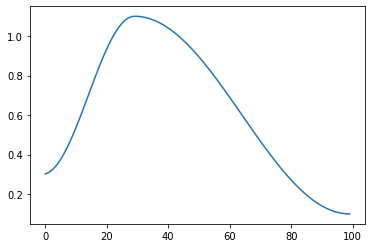

In [17]:
from torch import tensor
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + list(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 1.1), sched_cos(1.1, 0.1)])
a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)
plt.plot(a, [sched(o) for o in p])

In [0]:
# Defining how one training step will be computed.
# train() is used in each epoch later
sched = combine_scheds([0.3, 0.7], [sched_cos(1e-5, 1e-3), sched_cos(1e-3, 1e-6)])
learning_rates = list()

def train(train_loader, model, lm_criterion, crf_criterion, optimizer, epoch, vb_decoder, total_iters):
    """
    train_loader: DataLoader for training data
    model: LM_LSTM_CRF
    lm_criterion:  nn.CrossEntropyLoss()
    crf_criterion: ViterbiLoss()
    optimizer: SGD/adam/adbound whatever your choice is
    epoch: epoch number
    vb_decoder: viterbi decoder(to decode and find F1 score)
    """
    model.train()  # training mode, so dropout

    batch_time = AverageMeter()  # forward prop. + back prop. time per batch
    data_time = AverageMeter()  # data loading time per batch
    ce_losses = AverageMeter()  # cross entropy loss
    vb_losses = AverageMeter()  # viterbi loss
    f1s = AverageMeter()  # f1 score

    start = time.time()

    # Batches
    for i, (wmaps, cmaps_f, cmaps_b, cmarkers_f, cmarkers_b, tmaps, wmap_lengths, cmap_lengths) in enumerate(train_loader):
        data_time.update(time.time()-start)

        max_word_len = max(wmap_lengths.tolist())
        max_char_len = max(cmap_lengths.tolist())

        # Reduce batch's padded length to maximum in-batch sequence. 
        # This saves some compute on nn.Linear layers (RNNs are not affected, since they don't compute over the pads)
        wmaps = wmaps[:, :max_word_len].to(device)
        cmaps_f = cmaps_f[:, :max_char_len].to(device)
        cmaps_b = cmaps_b[:, :max_char_len].to(device)
        cmarkers_f = cmarkers_f[:, :max_word_len].to(device)
        cmarkers_b = cmarkers_b[:, :max_word_len].to(device)
        tmaps = tmaps[:, :max_word_len].to(device)
        wmap_lengths = wmap_lengths.to(device)
        cmap_lengths = cmap_lengths.to(device)

        # Forward prop.
        crf_scores, lm_f_scores, lm_b_scores, wmaps_sorted, tmaps_sorted, wmap_lengths_sorted, _, __ = model(cmaps_f,
                                                                                                             cmaps_b,
                                                                                                             cmarkers_f,
                                                                                                             cmarkers_b,
                                                                                                             wmaps,
                                                                                                             tmaps,
                                                                                                             wmap_lengths,
                                                                                                             cmap_lengths)
        
        # LM loss

        # We don't predict the next word at the pads or <end> tokens
        # Hence, only predict [word1, word2, word3, word4] among [word1, word2, word3, word4,<pad>,<pad>,<pad>,<pad>,<pad>,<end>]
        # So prediction lengths are word sequence lengths -1
        lm_lengths = wmap_lengths_sorted - 1 # (batch_size) the effective length of each row
        lm_lengths = lm_lengths.tolist()

        # Remove scores at timesteps we won't predict at
        # pack_padded_sequence is a good trick to do this (145 PyTorch tricks(my other repo)---Trick #11)
        lm_f_scores = pack_padded_sequence(lm_f_scores, lm_lengths, batch_first=True)
        lm_b_scores = pack_padded_sequence(lm_b_scores, lm_lengths, batch_first=True)

        # For the forward sequence, targets are from the second word onwards, up to <end>
        # (timestep -> target) ...dunston -> checks, ...checks -> in, ...in -> <end>
        lm_f_targets = wmaps_sorted[:, 1:]
        lm_f_targets = pack_padded_sequence(lm_f_targets, lm_lengths, batch_first=True)

        # For the backward sequence, targets are <end> followed by all words except the last word
        # ...notsnud -> <end>, ...skcehc -> dunston, ...ni -> checks
        lm_b_targets = torch.cat([torch.LongTensor([word_map['<end>']] * wmaps_sorted.size(0)).unsqueeze(1).to(device), 
                                  wmaps_sorted], dim=1)
        lm_b_targets = pack_padded_sequence(lm_b_targets, lm_lengths, batch_first=True)
        
        # Calculate loss
        ce_loss = lm_criterion(lm_f_scores.data, lm_f_targets.data) + lm_criterion(lm_b_scores.data, lm_b_targets.data)
        vb_loss = crf_criterion(crf_scores, tmaps_sorted, wmap_lengths_sorted)
        loss = ce_loss + vb_loss

        # Learning rate annealing
        current_iter = epoch*n_batches + i
        new_lr = sched(current_iter/total_iters)
        optimizer.param_groups[0]['lr'] = new_lr
        learning_rates.append(new_lr)
        # print(f'the learning rate in Epoch {epoch}, step {i} is {new_lr}')

        # Back-prop
        optimizer.zero_grad()
        loss.backward()
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)
        optimizer.step()

        # Viterbi decode to find accuracy/F1
        decoded = vb_decoder.decode(crf_scores.to("cpu"), wmap_lengths_sorted.to("cpu"))

        # Remove timesteps we won't predict at, and also <end> tags, because to predict them would be cheating
        decoded      = pack_padded_sequence(decoded, lm_lengths, batch_first=True)
        tmaps_sorted = tmaps_sorted % vb_decoder.tagset_size  # actual target indices (see create_input_tensors())
        tmaps_sorted = pack_padded_sequence(tmaps_sorted, lm_lengths, batch_first=True)

        # Compute F1
        f1 = f1_score(tmaps_sorted.data.to("cpu").numpy(), decoded.data.numpy(), average='macro')

        # Keep track of metrics
        ce_losses.update(ce_loss.item(), sum(lm_lengths))
        vb_losses.update(vb_loss.item(), crf_scores.size(0))
        batch_time.update(time.time() - start)
        f1s.update(f1, sum(lm_lengths))

        start = time.time()

        # Print training status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Load Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'CE Loss {ce_loss.val:.4f} ({ce_loss.avg:.4f})\t'
                  'VB Loss {vb_loss.val:.4f} ({vb_loss.avg:.4f})\t'
                  'F1 {f1.val:.3f} ({f1.avg:.3f})'.format(epoch, i, len(train_loader),
                                                          batch_time=batch_time,
                                                          data_time=data_time, ce_loss=ce_losses,
                                                          vb_loss=vb_losses, f1=f1s))
def validate(val_loader, model, crf_criterion, vb_decoder):
    """
    val_loader:    Dataloader for validation data
    model:         Model
    crf_criterion: Viterbi loss layer
    return:        validation F1 score
    """
    model.eval()

    batch_time = AverageMeter()
    vb_losses  = AverageMeter()
    f1s        = AverageMeter()

    start = time.time()

    # validation loops
    for i, (wmaps, cmaps_f, cmaps_b, cmarkers_f, cmarkers_b, tmaps, wmap_lengths, cmap_lengths) in enumerate(val_loader):
        max_word_len = max(wmap_lengths.tolist())
        max_char_len = max(cmap_lengths.tolist())

        # Reduce batch's padded length to maximum in-batch sequence
        # This saves some compute on nn.Linear layers (RNNs are unaffected, since they don't compute over the pads)
        wmaps = wmaps[:, :max_word_len].to(device)
        cmaps_f = cmaps_f[:, :max_char_len].to(device)
        cmaps_b = cmaps_b[:, :max_char_len].to(device)
        cmarkers_f = cmarkers_f[:, :max_word_len].to(device)
        cmarkers_b = cmarkers_b[:, :max_word_len].to(device)
        tmaps = tmaps[:, :max_word_len].to(device)
        wmap_lengths = wmap_lengths.to(device)
        cmap_lengths = cmap_lengths.to(device)

        # Forward prop.
        crf_scores, wmaps_sorted, tmaps_sorted, wmap_lengths_sorted, _, __ = model(cmaps_f,
                                                                                    cmaps_b,
                                                                                    cmarkers_f,
                                                                                    cmarkers_b,
                                                                                    wmaps,
                                                                                    tmaps,
                                                                                    wmap_lengths,
                                                                                    cmap_lengths)

        # Viterbi / CRF layer loss
        vb_loss = crf_criterion(crf_scores, tmaps_sorted, wmap_lengths_sorted)

        # Viterbi decode to find accuracy / f1
        decoded = vb_decoder.decode(crf_scores.to("cpu"), wmap_lengths_sorted.to("cpu"))

        # Remove timesteps we won't predict at, and also <end> tags, because to predict them would be cheating
        decoded      = pack_padded_sequence(decoded, (wmap_lengths_sorted - 1).tolist(), batch_first=True)
        tmaps_sorted = tmaps_sorted % vb_decoder.tagset_size  # actual target indices (see create_input_tensors())
        tmaps_sorted = pack_padded_sequence(tmaps_sorted, (wmap_lengths_sorted - 1).tolist(), batch_first=True)

        # f1
        f1 = f1_score(tmaps_sorted.data.to("cpu").numpy(), decoded.data.numpy(), average='macro')

        # Keep track of metrics
        vb_losses.update(vb_loss.item(), crf_scores.size(0))
        f1s.update(f1, sum((wmap_lengths_sorted - 1).tolist()))
        batch_time.update(time.time() - start)

        start = time.time()

        if i % print_freq == 0:
            print('Validation: [{0}/{1}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'VB Loss {vb_loss.val:.4f} ({vb_loss.avg:.4f})\t'
                  'F1 Score {f1.val:.3f} ({f1.avg:.3f})\t'.format(i, len(val_loader), batch_time=batch_time,
                                                                  vb_loss=vb_losses, f1=f1s))

    print(
        '\n * LOSS - {vb_loss.avg:.3f}, F1 SCORE - {f1.avg:.3f}\n'.format(vb_loss=vb_losses,
                                                                          f1=f1s))

    return f1s.avg    

In [0]:
# Loss funcitons
lm_criterion  = nn.CrossEntropyLoss().to(device)
crf_criterion = ViterbiLoss(tag_map).to(device)

# Since the language model's vocab is restricted on in-corpus indices, encode training/val with only these!
# word_map might have been expanded, and in-corpus words eliminated due to low frequency might still be added because
# they exist in the pre-trained embeddings.(these embeddings are added after the <unk> token)
temp_word_map = {k: v for k, v in word_map.items() if v <= word_map['<unk>']}

# train_input = (padded_wmaps, padded_cmaps_f, padded_cmaps_b, padded_cmarkers_f, padded_cmarkers_b, 
#                padded_tmaps, wmap_lengths,   cmap_lengths)
train_inputs = create_input_tensors(train_words, train_tags, temp_word_map, char_map,
                                        tag_map)
val_inputs = create_input_tensors(val_words, val_tags, temp_word_map, char_map, tag_map)

# DataLoaders
train_loader = torch.utils.data.DataLoader(WCDataset(*train_inputs), batch_size=batch_size, shuffle=True,
                                            num_workers=workers, pin_memory=False)
val_loader = torch.utils.data.DataLoader(WCDataset(*val_inputs), batch_size=batch_size, shuffle=True,
                                             num_workers=workers, pin_memory=False)

# Viterbi decoder (to find accuracy during validation)
vb_decoder = ViterbiDecoder(tag_map)

# Calculate total number of iterations for learning rate annealing
n_batches   = len(train_loader)
total_iters = epochs*n_batches
epochs_since_improvement = 0

# Epochs
for epoch in range(start_epoch, epochs):
    # One epoch's training
    train(train_loader  = train_loader,
          model         = model,
          lm_criterion  = lm_criterion,
          crf_criterion = crf_criterion,
          optimizer     = optimizer,
          epoch         = epoch,
          vb_decoder    = vb_decoder,
          total_iters   = total_iters
          )
    # One epoch's validation
    val_f1 = validate(val_loader = val_loader,
                      model      = model,
                      crf_criterion = crf_criterion,
                      vb_decoder    = vb_decoder)
    is_best = val_f1 > best_f1
    if not is_best:
        epochs_since_improvement += 1
        print("\nEpochs since improvement: %d\n" % (epochs_since_improvement,))
    else:
        epochs_since_improvement = 0
    
    # Save checkpoint
    save_checkpoint(epoch, model, optimizer, val_f1, word_map, char_map, tag_map, lm_vocab_size, is_best)

    # Decay learning rate every epoch
    # adjust_learning_rate(optimizer, lr / (1 + (epoch + 1) * lr_decay))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Epoch: [88][0/1405]	Batch Time 0.345 (0.345)	Data Load Time 0.188 (0.188)	CE Loss 11.4445 (11.4445)	VB Loss 0.5451 (0.5451)	F1 0.789 (0.789)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: [88][300/1405]	Batch Time 0.129 (0.123)	Data Load Time 0.004 (0.005)	CE Loss 11.4837 (11.1575)	VB Loss 0.2710 (1.9228)	F1 0.942 (0.779)
Epoch: [88][600/1405]	Batch Time 0.149 (0.123)	Data Load Time 0.004 (0.005)	CE Loss 10.9598 (11.1175)	VB Loss 4.3769 (1.9267)	F1 0.683 (0.775)
Epoch: [88][900/1405]	Batch Time 0.094 (0.123)	Data Load Time 0.004 (0.004)	CE Loss 10.3788 (11.1088)	VB Loss 0.6879 (1.9498)	F1 0.959 (0.772)
Epoch: [88][1200/1405]	Batch Time 0.105 (0.123)	Data Load Time 0.004 (0.004)	CE Loss 10.5042 (11.1092)	VB Loss 0.7330 (1.9629)	F1 0.932 (0.773)
Validation: [0/325]	Batch Time 0.264 (0.264)	VB Loss 1.0537 (1.0537)	F1 Score 0.930 (0.930)	


In [0]:
learning_rates